In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from random import choices

from sklearn.cluster import KMeans

print(tf.executing_eagerly())

print(tf.__version__)
print('GPUs available: {}'.format(len(tf.config.list_physical_devices('GPU'))))

True
2.2.0
GPUs available: 1


In [2]:
data_dir = "data/UCM.tfrecords"

In [3]:
# Define the features in the TFRecords file
features = {
    "image_raw": tf.io.FixedLenSequenceFeature(
        [], dtype=tf.float32, allow_missing=True
    ),
    "height": tf.io.FixedLenFeature([], tf.int64),
    "width": tf.io.FixedLenFeature([], tf.int64),
    "channels": tf.io.FixedLenFeature([], tf.int64),
    "label": tf.io.FixedLenFeature([], tf.int64),
}

In [4]:
def parse_example(example_proto):
    image_features = tf.io.parse_single_example(example_proto, features)
    
    height = tf.cast(image_features["height"], tf.int32)
    width = tf.cast(image_features["width"], tf.int32)
    channels = tf.cast(image_features["channels"], tf.int32)
    
    image_raw = tf.reshape(
        tf.squeeze(image_features["image_raw"]),
        tf.stack([height, width, channels])
    )
    
    target = image_features["label"]
    
    return image_raw, target

## Visualise the data

In [5]:
with open('data/label_dict.pkl', 'rb') as f:
    label_dict = pkl.load(f)

In [6]:
data = tf.data.TFRecordDataset(data_dir).map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)

data_viz = iter(data.batch(1))

Label: denseresidential
0.518327


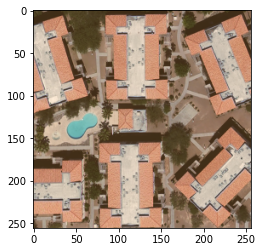

In [7]:
for i in range(50):
    img, label = next(data_viz)
plt.imshow(img.numpy()[0]) #Add 0.5 if it's zero-centered. (it's not quite 0.5 strictly but it's close enough)
print("Label: {}".format(label_dict[label.numpy()[0]]))
print(img.numpy()[0].mean())

## Build the model

Li 2016 - 

Li 2020 - 1e6 patches from 1e5 images

In [8]:
data_numpy = list(data.as_numpy_iterator()) #Could change this to not load whole dataset into memory if too big
num_images = len(data_numpy)
image_size = data_numpy[0][0].shape[0]
seed = 0

featureset_size = num_images * 10
no_featurelayers = 2
w = 6 #Size of receptive field for feature mapping
s = 2 #Size of local max pooling window

K = [150, 900]

In [9]:
%%time

feature_sets = []

#Randomly sample image patches - for the input layer
image_indices = choices(range(num_images), k = featureset_size)
row_indices = choices(range(image_size - w + 1), k = featureset_size)
col_indices = choices(range(image_size - w + 1), k = featureset_size)

feature_set = []

for i in range(len(image_indices)):
    ii, ri, ci = image_indices[i], row_indices[i], col_indices[i]
    sample_patch = data_numpy[ii][0][ri:ri+w,ci:ci+w]
    feature_set.append(sample_patch.flatten())
    
feature_set = np.array(feature_set)
feature_sets.append(feature_set)

kmeans = KMeans(n_clusters=K[0], random_state = seed).fit(feature_sets[0])    

CPU times: user 10min 33s, sys: 14min 38s, total: 25min 12s
Wall time: 1min 6s


In [82]:
class FeatureMapLayer(tf.keras.layers.Layer):
    def __init__(self, K, w):
        super(FeatureMapLayer, self).__init__()
        self.K = K
        self.w = w
        
    def build(self, input_shape):
        #assert self.K == visual_words.shape[0]
        #assert self.w**2 * input_shape[2] == visual_words.shape[1]
        self.visual_words = self.add_weight("visual_words", shape = [self.K, self.w**2 * input_shape[2]])
        #self.output_shape = (self.input_shape-self.w+1, self.input_shape-self.w+1, K)
        
    def get_patch_vector(self, image, loc):
        i, j = loc[0], loc[1]
        return tf.reshape(image[i:i+self.w, j:j+self.w], (1, -1))[0]
        
    def call(self, input):
        for i in range(input.shape[0]+1):
            for j in range(input.shape[1]+1):
                x = self.get_patch_vector(input, (i, j))
                print(x)
        return 5
        

In [89]:
x = np.array([[1,2,3],[4,5,6]])
print(x.reshape(1,-1))
print(x.flatten())
print(tf.reshape(x, (1,-1))[0])

[[1 2 3 4 5 6]]
[1 2 3 4 5 6]
tf.Tensor([1 2 3 4 5 6], shape=(6,), dtype=int64)


In [86]:
layer = FeatureMapLayer(K[0], w)
aLayer = layer(tf.zeros([256,256,3]))

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 108), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 108), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0

KeyboardInterrupt: 

In [19]:
visdict = kmeans.cluster_centers_

In [79]:
visdict

array([[0.655, 0.58 , 0.49 , ..., 0.44 , 0.377, 0.305],
       [0.333, 0.305, 0.24 , ..., 0.344, 0.314, 0.246],
       [0.891, 0.849, 0.765, ..., 0.896, 0.851, 0.769],
       ...,
       [0.796, 0.791, 0.758, ..., 0.368, 0.376, 0.353],
       [0.134, 0.154, 0.159, ..., 0.7  , 0.697, 0.652],
       [0.388, 0.37 , 0.366, ..., 0.3  , 0.292, 0.281]], dtype=float32)